In [1]:
#예제-6-5 # 
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, LSTM, SimpleRNN
#

In [2]:
# 이하 김만기님 setting 
import numpy as np
import tensorflow as tf
import random as python_random
# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(123)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
python_random.seed(123)

# The below set_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/random/set_seed
tf.random.set_seed(1234)
from keras import backend as K
#
import tensorflow.compat.v1 as tf # 텐서 이전버전의 라이브러리를 쓸 수 있도록 세팅하는 import로 추정됨 
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(),config=session_conf)
K.set_session(sess)
import tensorflow as tf
# 이상 김만기님 setting 

In [3]:
# time step만큼 시퀀스 데이터 분리
def split_sequence(sequence, step):
    x, y = list(), list()
    for i in range(len(sequence)):
        end_idx = i + step
        if end_idx > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_idx], sequence[end_idx]
        x.append(seq_x)
        y.append(seq_y)
    return np.array(x), np.array(y)

In [4]:
# sin 함수 학습 데이터 ❶
x = [i for i in np.arange(start=-10, stop=10, step=0.1)]
print(x)        # 서비스코드
print(len(x))   # 서비스코드
train_y = [np.sin(i) for i in x]
print(train_y)  # sin 함수 변환 결과를 리스트에 담음 
print(len(train_y))     # 서비스코드
# train_y 리스트는 RNN 모델 학습에 필요한 학습 데이터셋임

[-10.0, -9.9, -9.8, -9.700000000000001, -9.600000000000001, -9.500000000000002, -9.400000000000002, -9.300000000000002, -9.200000000000003, -9.100000000000003, -9.000000000000004, -8.900000000000004, -8.800000000000004, -8.700000000000005, -8.600000000000005, -8.500000000000005, -8.400000000000006, -8.300000000000006, -8.200000000000006, -8.100000000000007, -8.000000000000007, -7.9000000000000075, -7.800000000000008, -7.700000000000008, -7.6000000000000085, -7.500000000000009, -7.400000000000009, -7.30000000000001, -7.20000000000001, -7.10000000000001, -7.000000000000011, -6.900000000000011, -6.800000000000011, -6.700000000000012, -6.600000000000012, -6.500000000000012, -6.400000000000013, -6.300000000000013, -6.2000000000000135, -6.100000000000014, -6.000000000000014, -5.900000000000015, -5.800000000000015, -5.700000000000015, -5.600000000000016, -5.500000000000016, -5.400000000000016, -5.300000000000017, -5.200000000000017, -5.100000000000017, -5.000000000000018, -4.900000000000018, 

In [5]:
# 하이퍼파라미터 ❷
# n_timesteps 상수는 그림-6-26에서 h0 ~ h14까지 시퀀스를 15개로 
# 만든다는 의미를 설명하고 있음 
n_timesteps = 15  
n_features = 1

In [6]:
# 시퀀스 나누기 ➌  ---> 이 문단은 178페이지 그림-6-21에서
# 왼쪽 그림의 은닉층이 셀 한개에 되돌이화살표로 표현한 것을
# 오른 쪽그림에서 여러 개(h0, h1, h2, ... ht)로 분리한 것을 
# (이 예제에서는 15개임)의미함
#
# train_x.shape => (samples, timesteps)
# train_y.shape => (samples)
train_x, train_y = split_sequence(train_y, step=n_timesteps)
# sin 파형의 학습 데이터가 들어 있는 train_y 리스트에서 
# n_timesteps만큼 나눠서 입력 시퀀스(15개)를 생성함 
print('train_x-->',train_x)      # 서비스코드
print('train_y--->',train_y)     # 서비스코드
print("shape x:{} / y:{}".format(train_x.shape, train_y.shape))


train_x--> [[ 0.54402111  0.45753589  0.36647913 ... -0.58491719 -0.66296923
  -0.7343971 ]
 [ 0.45753589  0.36647913  0.27176063 ... -0.66296923 -0.7343971
  -0.79848711]
 [ 0.36647913  0.27176063  0.17432678 ... -0.7343971  -0.79848711
  -0.85459891]
 ...
 [ 0.94073056  0.90217183  0.85459891 ...  0.02477543 -0.07515112
  -0.17432678]
 [ 0.90217183  0.85459891  0.79848711 ... -0.07515112 -0.17432678
  -0.27176063]
 [ 0.85459891  0.79848711  0.7343971  ... -0.17432678 -0.27176063
  -0.36647913]]
train_y---> [-7.98487113e-01 -8.54598908e-01 -9.02171834e-01 -9.40730557e-01
 -9.69889811e-01 -9.89358247e-01 -9.98941342e-01 -9.98543345e-01
 -9.88168234e-01 -9.67919672e-01 -9.37999977e-01 -8.98708096e-01
 -8.50436621e-01 -7.93667864e-01 -7.28969040e-01 -6.56986599e-01
 -5.78439764e-01 -4.94113351e-01 -4.04849921e-01 -3.11541364e-01
 -2.15119988e-01 -1.16549205e-01 -1.68139005e-02  8.30894028e-02
  1.82162504e-01  2.79415498e-01  3.73876665e-01  4.64602179e-01
  5.50685543e-01  6.31266638e-0

In [7]:
# RNN 입력 벡터 크기를 맞추기 위해 벡터 차원 크기 변경 ❹ 
# 이 문단은 예제 이전에 RNN 설명에서는 누락된 듯함
# 개념적으로 백터 차원 크기 변경이란 입력 데이터를 모델링에 적합한
# 규격으로 변환하는 것을 의미함
# 184쪽 하단에 이와 관련한 설명이 조금 있음
''' 
 케라스에서 RNN 계층을 사용하려면 3차원 텐서 tensor 형태여야 합니다. 
 따라서 현재 2차원 (samples, time_step) 인 train_x를 
 RNN 모델의 입력 데이터 형상에 맞게 차원  
 (batch size, time step, input length) 형태로 변환합니다. 
'''
#
# reshape from [samples, timesteps] into [samples, timesteps, features]
train_x = train_x.reshape(train_x.shape[0], train_x.shape[1], n_features)
print("train_x.shape = {}".format(train_x.shape))
print("train_y.shape = {}".format(train_y.shape))

train_x.shape = (185, 15, 1)
train_y.shape = (185,)


In [25]:
# RNN 모델 정의 ❺
# RNN 모델을 정의하는 방법은 이전에 했던 것과 다른 부분이 있음 
# SimpleRNN 계층은 가장 간단한 형태의 RNN 계층임
# SimpleRNN 계층 1개와 출력을 위한 Dense 계층 1개로 구성되어 있음
#
#input_shape = 
model = Sequential()
model.add(SimpleRNN(units=10, return_sequences=False, input_shape=(n_timesteps, n_features)))
    # units는 RNN 계층에 존재하는 전체 뉴런 수입니다. 아래 참고예제와 비교하면 상단 청색 블럭의 h3's dimension 10개임
    # input_shape(15,1) 에서 15를 아래 참고예제와 비교하면 상단 녹색 블럭이 15개임 / 1은 아웃풋디멘전이 1임  
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# 옵티마이저를 무엇을 선택하는지가 변수가 될 수 있습니다.

 # 참고예제 
# 시퀀스 예측 모델 정의
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(units=10, return_sequences=False, input_shape=[4,1]),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()
위 예제의 SimpleRNN() 설명은 다음과 같다.
tf.keras.Sequential을 사용하여 SimpleRNN 레이어와 Dense 레이어를 차례대로 쌓음
위에서 사용한 SimpleRNN 레이어의 인자는 아래와 같음
units : 양의 정수 값, 출력 값 (Hidden state)의 차원
return_sequences : Boolean 값, 마지막 출력 값만 반환할 것인지 전체 계층의 출력 값을 반환할 것인지 결정
input_shape : 입력 데이터의 형태 , [4 , 1]에서 4는 timesteps 즉, 계층의 갯수이고 1은 입력 데이터의 차원
그리고 정의한 모델의 구조를 그림으로 나타내면 아래와 같습니다.

In [ ]:
from IPython.display import Image
Image('img01.png')

In [27]:
# 모델 학습 ❻
np.random.seed(0)
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='loss', patience=5, mode='auto')
#batch_size=1
history = model.fit(train_x, train_y, batch_size = 1, epochs=1000, callbacks=[early_stopping])


Epoch 1/1000
185/185 [==============================] - 0s 2ms/step - loss: 0.0020
Epoch 2/1000
185/185 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 3/1000
185/185 [==============================] - 0s 2ms/step - loss: 0.0019
Epoch 4/1000
185/185 [==============================] - 0s 2ms/step - loss: 0.0014
Epoch 5/1000
185/185 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 6/1000
185/185 [==============================] - 0s 2ms/step - loss: 3.2237e-04
Epoch 7/1000
185/185 [==============================] - 0s 2ms/step - loss: 0.0014
Epoch 8/1000
185/185 [==============================] - 0s 2ms/step - loss: 3.0290e-04
Epoch 9/1000
185/185 [==============================] - 0s 2ms/step - loss: 4.4396e-04
Epoch 10/1000
185/185 [==============================] - 0s 2ms/step - loss: 3.6557e-04
Epoch 11/1000
185/185 [==============================] - 0s 2ms/step - loss: 0.0014
Epoch 12/1000
185/185 [==============================] - 0s 2ms/step 

In [11]:
history.model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 10)                120       
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


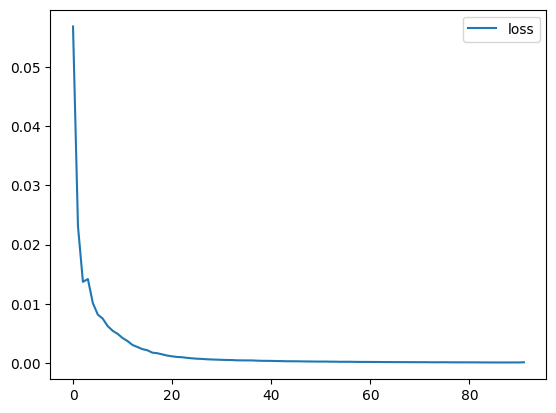

In [10]:
# loss 그래프 생성 ❼
plt.plot(history.history['loss'], label="loss")
plt.legend(loc="upper right")
plt.show()

In [11]:
# 테스트 데이터셋 생성 ❽
test_x = np.arange(10, 20, 0.1)
calc_y = np.cos(test_x) # 테스트 정답 데이터

In [12]:
# RNN 모델 예측 및 로그 저장 ❾
test_y = calc_y[:n_timesteps]
for i in range(len(test_x) - n_timesteps):
    net_input = test_y[i : i + n_timesteps]
    net_input = net_input.reshape((1, n_timesteps, n_features))
    train_y = model.predict(net_input, verbose=0)
    print(test_y.shape, train_y.shape, i, i + n_timesteps)
    test_y = np.append(test_y, train_y)

(15,) (1, 1) 0 15
(16,) (1, 1) 1 16
(17,) (1, 1) 2 17
(18,) (1, 1) 3 18
(19,) (1, 1) 4 19
(20,) (1, 1) 5 20
(21,) (1, 1) 6 21
(22,) (1, 1) 7 22
(23,) (1, 1) 8 23
(24,) (1, 1) 9 24
(25,) (1, 1) 10 25
(26,) (1, 1) 11 26
(27,) (1, 1) 12 27
(28,) (1, 1) 13 28
(29,) (1, 1) 14 29
(30,) (1, 1) 15 30
(31,) (1, 1) 16 31
(32,) (1, 1) 17 32
(33,) (1, 1) 18 33
(34,) (1, 1) 19 34
(35,) (1, 1) 20 35
(36,) (1, 1) 21 36
(37,) (1, 1) 22 37
(38,) (1, 1) 23 38
(39,) (1, 1) 24 39
(40,) (1, 1) 25 40
(41,) (1, 1) 26 41
(42,) (1, 1) 27 42
(43,) (1, 1) 28 43
(44,) (1, 1) 29 44
(45,) (1, 1) 30 45
(46,) (1, 1) 31 46
(47,) (1, 1) 32 47
(48,) (1, 1) 33 48
(49,) (1, 1) 34 49
(50,) (1, 1) 35 50
(51,) (1, 1) 36 51
(52,) (1, 1) 37 52
(53,) (1, 1) 38 53
(54,) (1, 1) 39 54
(55,) (1, 1) 40 55
(56,) (1, 1) 41 56
(57,) (1, 1) 42 57
(58,) (1, 1) 43 58
(59,) (1, 1) 44 59
(60,) (1, 1) 45 60
(61,) (1, 1) 46 61
(62,) (1, 1) 47 62
(63,) (1, 1) 48 63
(64,) (1, 1) 49 64
(65,) (1, 1) 50 65
(66,) (1, 1) 51 66
(67,) (1, 1) 52 67
(68

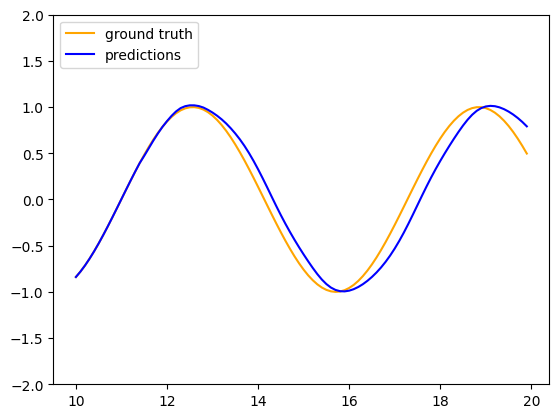

In [13]:
# 예측 결과 그래프 그리기 ❿
plt.plot(test_x, calc_y, label="ground truth", color="orange")
plt.plot(test_x, test_y, label="predictions", color="blue")
plt.legend(loc='upper left')
plt.ylim(-2, 2)
plt.show()